<a href="https://colab.research.google.com/github/abenya82/ZTM_tensorflow_02/blob/main/05_ZTM_transfer_learning_in__tf_part_2_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  Fine tuning


In [2]:
# gpu check
!nvidia-smi

Tue Jun 15 01:42:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## Creating helper functions



In [4]:
#from mr bourke's github
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-06-15 01:42:34--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-06-15 01:42:34 (89.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [6]:
## lets get some data



In [7]:
# get 10% of training data of 10 classes of food 101

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")


--2021-06-15 01:42:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.65.80, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   128MB/s    in 1.3s    

2021-06-15 01:42:38 (128 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [8]:
#check how many images and subdirectories are in the dataset
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

In [9]:
#create training and test directory paths

train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [10]:
# image_dataset_from_directory 
##  makes a tf.data.dataset datatype, and it's faster!


In [11]:
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode='categorical',
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode='categorical',
                                                                batch_size=BATCH_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [12]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [13]:
#makes batches of 32 images of size 224 by 224 split into 3 color channels
# None is the place holder for each batch of 32 images
#This is the input shape of the data going into the model


In [14]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [15]:
for images, labels in train_data_10_percent.take(1):
    print(images,labels)

tf.Tensor(
[[[[8.83163300e+01 6.53163300e+01 4.93163261e+01]
   [8.72602005e+01 6.31887741e+01 4.62602043e+01]
   [8.85765305e+01 6.23571434e+01 4.47908173e+01]
   ...
   [1.38265333e+01 1.29642744e+01 1.09642744e+01]
   [1.23417816e+01 8.34178162e+00 5.34178162e+00]
   [1.28318043e+01 8.54609013e+00 4.18894720e+00]]

  [[8.54234695e+01 5.93520432e+01 4.64948997e+01]
   [9.31326523e+01 6.51326523e+01 5.12755089e+01]
   [9.24285736e+01 6.48877563e+01 4.82704086e+01]
   ...
   [1.18927155e+01 1.00662470e+01 6.73455381e+00]
   [1.09234686e+01 6.92346859e+00 3.92346859e+00]
   [1.54542236e+01 1.24542236e+01 7.45422363e+00]]

  [[7.34438782e+01 4.64438782e+01 3.70153046e+01]
   [9.14030609e+01 6.41887741e+01 5.29744911e+01]
   [9.08571472e+01 6.24744911e+01 4.96173477e+01]
   ...
   [1.67193356e+01 1.25050726e+01 9.50507259e+00]
   [1.08826714e+01 7.66838551e+00 3.09695649e+00]
   [1.65153980e+01 1.35153980e+01 8.51539803e+00]]

  ...

  [[3.86175575e+01 4.40461464e+01 3.76175575e+01]
   [2

In [16]:
#notice the shape at the end!
#  this data is 
    # 32(images per batch) by 224(image height) by 224(image width) by 3(rgb)
#  the one-hotted matrix is the cooresponding labels!


Modelling Experiements we are running!

Model 0 - Baseline
    Data: 10 classes of Food 101 data random 10% training data
    Preprocessing: None
    Model: Feature Extractor: EfficientNet80 
                (pre-trained on ImageNet, all layers
                    frozen) with no top

Model 1 - 
    Data: 10 classes of Food 101 data random 1% training data
    Preprocessing: Random Flip
                    Rotation
                    Zoom
                    Height/ Width Augmentation
    Model: Feature Extractor: EfficientNet80 
                (pre-trained on ImageNet, all layers
                    frozen) with no top

Model 2 - 
    Data: 10 classes of Food 101 data random 10% training data
    Preprocessing: Random Flip
                    Rotation
                    Zoom
                    Height/ Width Augmentation
    Model: Feature Extractor: EfficientNet80 
                (pre-trained on ImageNet, all layers
                    frozen) with no top

Model 3 - 
    Data: 10 classes of Food 101 data random 10% training data
    Preprocessing: Random Flip
                    Rotation
                    Zoom
                    Height/ Width Augmentation
    Model: Feature Extractor: EfficientNet80 
                with top layer trained on custom data
                top 10 layers unfrozen



Model 4 - 
    Data: 10 classes of Food 101 data random 100% training data
    Preprocessing: Random Flip
                    Rotation
                    Zoom
                    Height/ Width Augmentation
    Model: Feature Extractor: EfficientNet80 
                with top layer trained on custom data
                top 10 layers unfrozen

In [17]:
# keras functional API
## compiling and fitting are the same

## functional API is more flexible and can make more complicated models


In [18]:
# 1. Create base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False) #we want to add our own dense layer on top

# 2. Freeze base model (so the underlying pretrained patterns are not updated in training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_layer")

# 4. If using ResNet50V2, you will need to normalize inputs (not needed for efficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base model
x = base_model(inputs)
print(f"Shape of inputs after passing through base model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information to reduce computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)   # (x) on end to pass data through layer
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax',name='output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the Model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. fit the model
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 validation_steps=int(0.25 * len(test_data)),  # Evaluating on 1/4 of test data
                                 callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                        experiment_name="10_percent_feature_extraction")])

16711680/16705208 [==============================] - 0s 0us/step
Shape of inputs after passing through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20210615-014249
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 43s 324ms/step - loss: 1.9997 - accuracy: 0.3493 - val_loss: 1.3751 - val_accuracy: 0.7237
Epoch 2/5
24/24 [==============================] - 5s 210ms/step - loss: 1.2028 - accuracy: 0.7107 - val_loss: 0.9205 - val_accuracy: 0.7928
Epoch 3/5
24/24 [==============================] - 5s 207ms/step - loss: 0.8715 - accuracy: 0.8067 - val_loss: 0.7177 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 5s 212ms/step - loss: 0.7069 - accuracy: 0.8307 - val_loss: 0.6299 - val_accuracy: 0.8372
Epoch 5/5
24/24 [==============================] - 5s 202ms/step - loss: 0.6046 - accuracy: 0.8587 - val_loss: 0.5761 - val_accuracy: 0.8503


In [19]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 114ms/step - loss: 0.6125 - accuracy: 0.8440


[0.6125229597091675, 0.843999981880188]

In [20]:
#check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [21]:
# summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [22]:
# summary of whole model
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


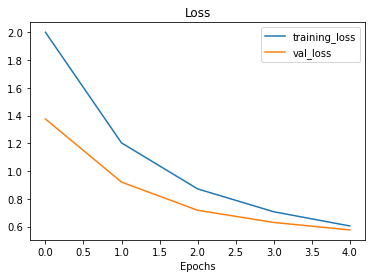

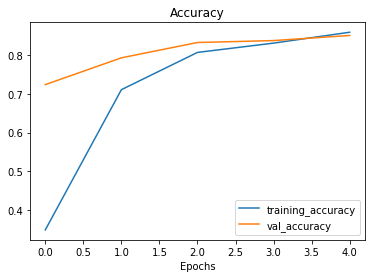

In [23]:
# Neato!

# the only trainedable parameters are in the output layer

# check out the training curves
plot_loss_curves(history_10_percent)

In [24]:
## getting a feature vector from a trained model

# lets demonstrate the Global Average Pooling Layer

#After base model shape of data is (None, 7, 7, 1280)

# after AverageGlobalPooling is turns to (None, 1280)

## lets use a similar shaped tensor of 1,4,4,3 and pass it to GlobalAveragePooling


In [25]:
input_shape = (1,4,4,3)

#create random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

#pass the random tensor through a average pooling 2d layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"After Global Average Pooling 2D: \n {global_average_pooled_tensor}\n")
print(global_average_pooled_tensor.shape)

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

After Global Average Pooling 2D: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

(1, 3)


In [26]:
# Let's replicate the Global Average Pooling2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [27]:
# feature vector is a learned representation of the input data (a compressed form of the input data based on how the model sees it)


In [28]:
# running a series of transfer learning experiments
# model 1 use feature extraction transfer learning with 1% of the training data with data augmentation
# model 2 use feature extraction transfer learning with 10% of the training data with data augmentation
# model 3 use fine-tuning transfer leanring on 10% of the training data with data augmentation
# model 4 use fine-tuning transfer learning on 100% of the training data with data augmentation


In [29]:
# Download and unzip data - preprocessed from food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2021-06-15 01:44:18--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.63.128, 142.250.31.128, 142.250.73.240, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.63.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   226MB/s    in 0.6s    

2021-06-15 01:44:18 (226 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [30]:
# create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"


In [31]:
#how many images are there?
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'

In [32]:
# only 7 training images per class!!!!
# set up data loaders


In [33]:
IMG_SIZE = (224,224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [34]:
## Adding data augmentation right into the model
# use layers inside:
# tf.keras.layers.experimental.preprocessing()

# data augmentation in the model allows GPU acceleration
#  image data augmentation only happens during training
#  whole model can still be exported and used elsewhere
#   does not augment testing data or unseen data

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# create data augmentation stage with horizontal flipping, rotations, etc

data_augmentation = keras.Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255)  # Use with resnet

    ], name='data_augmentation')



In [36]:
### visualize the data augmentation layer


In [37]:
# view random image, and compare to augmented version

Text(0.5, 1.0, 'augmented random image from class: pizza')

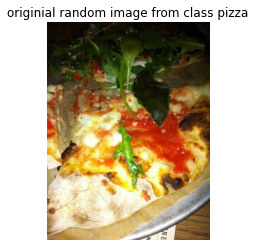

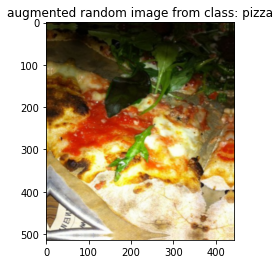

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class

random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image
#read in random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"originial random image from class {target_class}")
plt.axis(False)

# lets plot the augmented random image
augmented_img = data_augmentation(tf.expand_dims(img,axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"augmented random image from class: {target_class}")

In [39]:
## Model 1:  feature extraction transfer learning on 1% of training data with data augmentation


In [40]:
#setup input shape and freeze base layers

input_shape = (224,224,3)
print(IMG_SIZE)

(224, 224)


In [41]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=input_shape, name="input_layer")

# add in data augmentation

x = data_augmentation(inputs)

#give base model the inputs after augmentation and dont train it
x = base_model(x, training=False)

# Pool ouput features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

#make a model using inputs and outputs

model_1 = keras.Model(inputs,outputs)

#compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25 * len(test_data)),
                                #track model training logs
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="1_percent_data")])

Saving TensorBoard log files to: transfer_learning/1_percent_data/20210615-014423
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


3/3 [==============================] - 12s 3s/step - loss: 2.4497 - accuracy: 0.0429 - val_loss: 2.2619 - val_accuracy: 0.1135
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1992 - accuracy: 0.0857 - val_loss: 2.1350 - val_accuracy: 0.2336
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 1.9915 - accuracy: 0.3857 - val_loss: 2.0204 - val_accuracy: 0.3092
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8292 - accuracy: 0.5143 - val_loss: 1.9358 - val_accuracy: 0.3766
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6788 - accuracy: 0.6571 - val_loss: 1.8426 - val_accuracy: 0.4589


In [42]:
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"


In [43]:
# set data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE)


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [44]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
random_flip (RandomFlip)     (None, None, None, 3)     0         
_________________________________________________________________
random_rotation (RandomRotat (None, None, None, 3)     0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, None, None, 3)     0         
_________________________________________________________________
random_height (RandomHeight) (None, None, None, 3)     0         
_________________________________________________________________
random_width (RandomWidth)   (None, None, None, 3)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [45]:
# create model 2 with data augmentation built in
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# build data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomRotation(0.2),
    #preprocessing.Rescaling(1./255),
        ],
    name='data_augmentation')

# set up the input shape into the model
input_shape = (224,224,3)

#Create a frozen base model (aka backbone)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#create inputs and outputs (including layers in between)
inputs = layers.Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False) # pass augmented images to base model, but keeps base model in inference mode
        # ensures batch norm layers are not updated
        # DO NOT UPDATE batch normalization layers while fine tuning   -- training=False

x = layers.GlobalAveragePooling2D(name='Global_Average_Pooling2D')(x)
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

model_2 = tf.keras.Model(inputs,outputs)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])



In [46]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
Global_Average_Pooling2D (Gl (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [47]:
# want to make a callback checkpoint!!
# the model checkpoint callback intermediately saves the model or just the weights during training.
# this is useful so we can come back and start where we left off


In [48]:
# Set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

#Create a model checkpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq='epoch', #save every epoch
                                                         verbose=1)

In [49]:
inital_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                epochs=inital_epochs,
                                steps_per_epoch=len(train_data_10_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                       experiment_name="10_percent_data_aug"),
                                           checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210615-014454
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 23s 724ms/step - loss: 2.0094 - accuracy: 0.3307 - val_loss: 1.4856 - val_accuracy: 0.6382

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 11s 441ms/step - loss: 1.3484 - accuracy: 0.6667 - val_loss: 1.0244 - val_accuracy: 0.7977

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 9s 373ms/step - loss: 1.0586 - accuracy: 0.7373 - val_loss: 0.8313 - val_accuracy: 0.8043

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 422ms/step - loss: 0.8961 - accuracy: 0.7920 - val_loss: 0.6991 - val_accuracy: 0.8405

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 9s 356ms/step - loss: 0.7891 - accuracy: 0.7960 - val_lo

In [50]:
model_0.evaluate(test_data)

79/79 [==============================] - 10s 110ms/step - loss: 0.6125 - accuracy: 0.8440


[0.612523078918457, 0.843999981880188]

In [51]:
results_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.6895 - accuracy: 0.8128


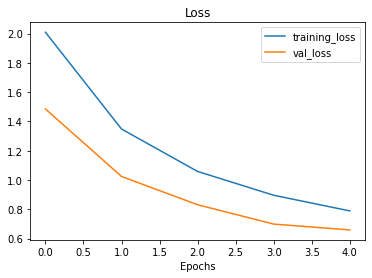

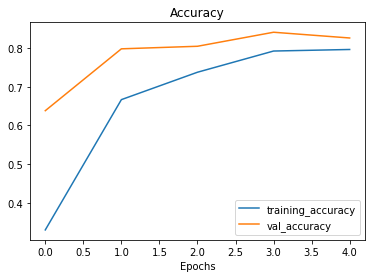

In [52]:
#plot model loss curves
plot_loss_curves(history_10_percent_data_aug)

In [53]:
### Loading in checkpointed weights

# returns a model to a speicific checkpoint

# load in saved model weights and evaluate model

In [54]:
model_2.load_weights(checkpoint_path)

In [55]:
# evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 110ms/step - loss: 0.6895 - accuracy: 0.8128


In [56]:
# these are the same as the previous evaluated test data!


In [57]:
## In fine-tuning, some layers are unfrozen
## we will unfreeze and train an arbitrary number of layers
### in finetuning, if you unfreeze layers, usually you unfreeze layers closer to the output
## Fine tuning usually works best after training a feature extraction model for a few epochs with large amounts of data

# build feature extractor
# unfreeze some layers



## Model 3: Fine tuning an existing model of 10% of the data

In [58]:
#layers in loaded model
model_2.layers

In [59]:
# are these layers trainable?
for layer in model_2.layers:
    print (layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f02e4df6c10> True
<tensorflow.python.keras.engine.sequential.Sequential object at 0x7f01e95f6290> True
<tensorflow.python.keras.engine.functional.Functional object at 0x7f01e913f150> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f01e9153cd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f01e9182c10> True


In [60]:
# functional layer is not trainable
# that is base_model

# look into that layer:
for layer in model_2.layers[2].layers:
    print(layer.name, layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [61]:
for layer in model_2.layers[2].layers:
    if layer.trainable:
        print(layer.name)

In [62]:
# none are trainable!
# for finetuning we want to unfreeze the top 10 layers

#how many trainable variables are in our base model?
print(len(model_2.layers[2].trainable_variables))

0


In [63]:
#NONE!

# to begin fine tuning, lets start by setting the last 10 layers of our base model to trainable

base_model.trainable = True

#freeze all layers except last 10
for layer in base_model.layers[:-10]:
    layer.trainable = False


In [64]:
# recompile (needed when we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  #when you fine tune, reduce the lr by 10x
                metrics=['accuracy'])

In [65]:
#check the trainable layers
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [66]:
# notice some of the layers are unfrozen
# how many trainable variables are there
print(len(model_2.trainable_variables))

12


In [67]:
initial_epochs = 5
fine_tune_epochs = initial_epochs + 5

history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], #start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine/20210615-014642
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 543ms/step - loss: 0.7041 - accuracy: 0.8000 - val_loss: 0.5379 - val_accuracy: 0.8322
Epoch 6/10
24/24 [==============================] - 9s 378ms/step - loss: 0.5748 - accuracy: 0.8213 - val_loss: 0.4867 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 10s 393ms/step - loss: 0.5063 - accuracy: 0.8560 - val_loss: 0.4931 - val_accuracy: 0.8421
Epoch 8/10
24/24 [==============================] - 10s 410ms/step - loss: 0.4618 - accuracy: 0.8640 - val_loss: 0.4678 - val_accuracy: 0.8520
Epoch 9/10
24/24 [==============================] - 10s 403ms/step - loss: 0.4100 - accuracy: 0.8680 - val_loss: 0.4902 - val_accuracy: 0.8372
Epoch 10/10
24/24 [==============================] - 9s 387ms/step - loss: 0.3672 - accuracy: 0.8987 - val_loss: 0.4816 - val_accuracy: 0.8569


In [68]:
# evaluate the fine tuned model (this is model3: which is model 2 fine tuned for 5 more epochs)

results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 111ms/step - loss: 0.4979 - accuracy: 0.8372


In [69]:
results_10_percent_data_aug

[0.6894832849502563, 0.8127999901771545]

In [70]:
results_fine_tune_10_percent

[0.4978730380535126, 0.8371999859809875]

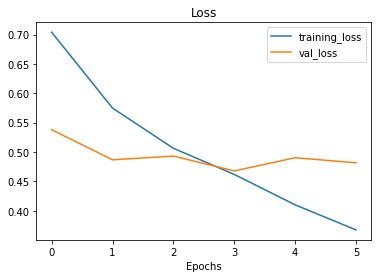

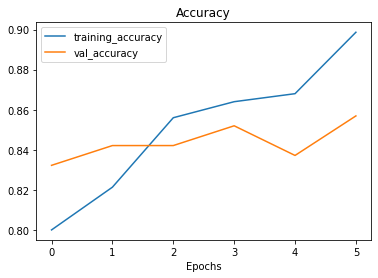

In [71]:
# inspect loss curves
plot_loss_curves(history_fine_10_percent_data_aug)

In [72]:
# lets make a function to compare training histories

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares 2 Tensorflow history objects
    """
    # get orginial history measurements
    acc = original_history.history['accuracy']
    loss = original_history.history['loss']

    val_acc = original_history.history['val_accuracy']
    val_loss = original_history.history['val_loss']
 
    # combine orginial history
    total_acc = acc + new_history.history['accuracy']
    total_loss = loss + new_history.history['loss']

    total_val_acc = val_acc + new_history.history['val_accuracy']
    total_val_loss = val_loss + new_history.history['val_loss']

    #make plot for accuracy
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,1)
    plt.plot(total_acc,label='training accuracy')
    plt.plot(total_val_acc,label='val accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    #make plot for loss
    plt.figure(figsize=(8,8))
    plt.subplot(2,1,2)
    plt.plot(total_loss,label='training loss')
    plt.plot(total_val_loss,label='val loss')
    plt.plot([initial_epochs-1, initial_epochs-1],plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

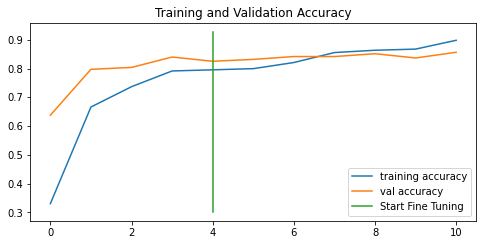

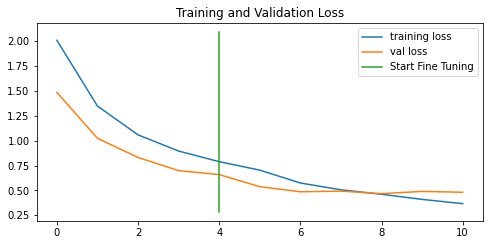

In [73]:
compare_historys(history_10_percent_data_aug,
                 history_fine_10_percent_data_aug,
                 initial_epochs=5)

In [74]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
unzip_data("10_food_classes_all_data.zip")

--2021-06-15 01:48:07--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.73.208, 142.250.65.80, 142.250.81.208, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.73.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   186MB/s    in 2.7s    

2021-06-15 01:48:10 (186 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



In [75]:
#setup training and test data dir

train_dir_all_data = "10_food_classes_all_data/train"
test_data = "10_food_classes_all_data/test"

In [76]:
walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 

In [77]:
# set up data inputs
import tensorflow as tf
IMG_SIZE = (224,224)
BATCH_SIZE = 32
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode='categorical',
                                                                                 batch_size=BATCH_SIZE,
                                                                                 image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [78]:
# load weights from checkpoint, so we can fine tune the same
#    stage the 10 percent data model was tuned from


In [79]:
model_2.load_weights(checkpoint_path)


In [80]:
# verify that model was rolled back
print(model_2.evaluate(test_data))
print(results_10_percent_data_aug)

79/79 [==============================] - 9s 111ms/step - loss: 0.6895 - accuracy: 0.8128
[0.6894832253456116, 0.8127999901771545]
[0.6894832849502563, 0.8127999901771545]


In [81]:
#check which layers are tunable
for layer_number, layer in enumerate(model_2.layers):
    print(layer_number,layer.name,layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 Global_Average_Pooling2D True
4 output_layer True


In [82]:
# let's inspect the base model
for layer_number, layer in enumerate(model_2.layers[2].layers):
    print(layer_number,layer.name,layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [83]:
#the last 10 are trainable!

In [84]:
# the model has been changed, so now we need to:
#  Compile!



In [85]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=['accuracy'])

In [86]:
fine_tune_epochs = initial_epochs + 5

history_fine_10_classes_full = model_2.fit(train_data_10_classes_full,
                                           epochs=fine_tune_epochs,
                                           validation_data=test_data,
                                           validation_steps=int(0.25*len(test_data)),
                                           initial_epoch=history_10_percent_data_aug.epoch[-1],
                                           callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='full_10_classes_fine_tune')])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune/20210615-014826
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 53s 200ms/step - loss: 0.7379 - accuracy: 0.7677 - val_loss: 0.4255 - val_accuracy: 0.8586
Epoch 6/10
235/235 [==============================] - 58s 244ms/step - loss: 0.5916 - accuracy: 0.8113 - val_loss: 0.3762 - val_accuracy: 0.8734
Epoch 7/10
235/235 [==============================] - 54s 226ms/step - loss: 0.5342 - accuracy: 0.8288 - val_loss: 0.3386 - val_accuracy: 0.8898
Epoch 8/10
235/235 [==============================] - 49s 207ms/step - loss: 0.4855 - accuracy: 0.8445 - val_loss: 0.3752 - val_accuracy: 0.8766
Epoch 9/10
235/235 [==============================] - 50s 209ms/step - loss: 0.4497 - accuracy: 0.8547 - val_loss: 0.3762 - val_accuracy: 0.8766
Epoch 10/10
235/235 [==============================] - 47s 199ms/step - loss: 0.4155 - accuracy: 0.8665 - val_loss: 0.3297 - val_accuracy: 0.8964


In [87]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 9s 112ms/step - loss: 0.3235 - accuracy: 0.8980


[0.32349032163619995, 0.8980000019073486]

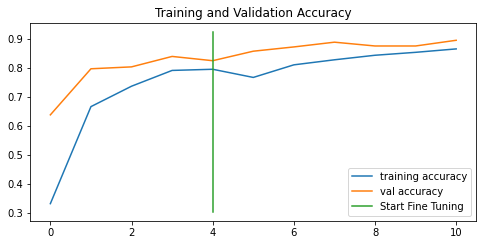

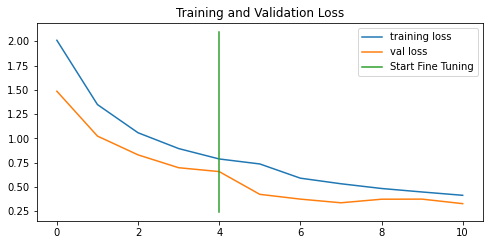

In [88]:
compare_historys(original_history=history_10_percent_data_aug,
                 new_history=history_fine_10_classes_full, 
                 initial_epochs=initial_epochs)

In [89]:
# Viewing our experiment data on Tensorboard

In [90]:
!tensorboard dev upload --logdir ./transfer_learning \
    --name "transfer learning experiments with 10 food101 classes"\
    --description "A series of different transfer learning experiments"\
    --one_shot # exits the uploader when finished

2021-06-15 01:55:18.891517: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3

In [90]:
# Done. View your TensorBoard at https://tensorboard.dev/experiment/867PulrIR1eraIL3plbePg/



Exercises

    Write a function to visualize an image from any dataset (train or test file) and any class (e.g. "steak", "pizza"... etc), visualize it and make a prediction on it using a trained model.
    Use feature-extraction to train a transfer learning model on 10% of the Food Vision data for 10 epochs using tf.keras.applications.EfficientNetB0 as the base model. Use the ModelCheckpoint callback to save the weights to file.
    Fine-tune the last 20 layers of the base model you trained in 2 for another 10 epochs. How did it go?
    Fine-tune the last 30 layers of the base model you trained in 2 for another 10 epochs. How did it go?

📖 Extra-curriculum

    Read the documentation on data augmentation in TensorFlow.
    Read the ULMFit paper (technical) for an introduction to the concept of freezing and unfreezing different layers.
    Read up on learning rate scheduling (there's a TensorFlow callback for this), how could this influence our model training?
        If you're training for longer, you probably want to reduce the learning rate as you go... the closer you get to the bottom of the hill, the smaller steps you want to take. Imagine it like finding a coin at the bottom of your couch. In the beginning your arm movements are going to be large and the closer you get, the smaller your movements become.



In [91]:


# View previous experiments
!tensorboard dev list



2021-06-15 02:00:02.454814: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/867PulrIR1eraIL3plbePg/
	Name                 transfer learning experiments with 10 food101 classes
	Description          A series of different transfer learning experiments
	Id                   867PulrIR1eraIL3plbePg
	Created              2021-06-15 01:55:36 (4 minutes ago)
	Updated              2021-06-15 01:55:41 (4 minutes ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4220447
https://tensorboard.dev/experiment/TetgSeUrTjGfYQjDa2dReg/
	Name                 Rez v Eff
	Description          Comparing 2 models
	Id                   TetgSeUrT

In [90]:
# Remove previous experiments
# !tensorboard dev delete --experiment_id OUbW0O3pRqqQgAphVBxi8Q